#### Importación de librerias

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#### Carga y formateo de datos

In [2]:
# Cargar Datos
piezo_df = pd.read_csv(
    '../data/processed/03_daily/piezo-data_SDH1PS01_daily.csv', 
    parse_dates=['Timestamps'], index_col='Timestamps',
    usecols=['Timestamps', 'depth_m']
)

soil_df = pd.read_csv(
    '../data/processed/03_daily/soil-data_z6-25818_daily.csv', 
    parse_dates=['Timestamps'], index_col='Timestamps',
    usecols=['Timestamps',
             'TEROS12_15cm_water-content_m3/m3', 'TEROS12_30cm_water-content_m3/m3', 'TEROS12_48cm_water-content_m3/m3',
             'TEROS12_15cm_soil-temperature_degree_C', 'TEROS12_30cm_soil-temperature_degree_C', 'TEROS12_48cm_soil-temperature_degree_C']
)

# Diccionarios de mapeo para nombres más limpios y extracción de metadatos
# Formato: Sensor_Profundidad_Variable
soil_rename_map = {
    'TEROS12_15cm_water-content_m3/m3': 'Suelo_15cm_Contenido-agua',
    'TEROS12_30cm_water-content_m3/m3': 'Suelo_30cm_Contenido-agua',
    'TEROS12_48cm_water-content_m3/m3': 'Suelo_48cm_Contenido-agua',
    'TEROS12_15cm_soil-temperature_degree_C': 'Suelo_15cm_Temperatura',
    'TEROS12_30cm_soil-temperature_degree_C': 'Suelo_30cm_Temperatura',
    'TEROS12_48cm_soil-temperature_degree_C': 'Suelo_48cm_Temperatura'
}

# Renombrar columnas
soil_df = soil_df.rename(columns=soil_rename_map)
piezo_df = piezo_df.rename(columns={'depth_m': 'Piezometro_NA_Profundidad-nivel-freatico'})

# Unir datasets
df_merged = pd.merge(piezo_df, soil_df, left_index=True, right_index=True, how='inner')

# Transformar a formato largo
df_long = df_merged.reset_index().melt(id_vars='Timestamps', var_name='metadata', value_name='Valor')

# Extraer metadatos dividiendo el string por guiones bajos (estructura: Sensor_Profundidad_Variable)
metadata_split = df_long['metadata'].str.split('_', expand=True)
df_long['Sensor'] = metadata_split[0]           # Ej: Suelo, Piezometro
df_long['Profundidad'] = metadata_split[1]  # Ej: 15cm, 30cm, NA
df_long['Variable'] = metadata_split[2]         # Ej: Contenido-agua, Temperatura

# Generacion de un espacio entre el numero y la unidad para etiquetas
df_long['Profundidad_label'] = df_long['Profundidad'].str.replace('cm', ' cm').replace('NA', 'NA')

# Definir etiquetas limpias para los gráficos
variable_labels = {
    'Profundidad-nivel-freatico': 'Prof. del nivel freático (m)',
    'Contenido-agua': 'Contenido de agua (m³/m³)',
    'Temperatura': 'Temperatura (°C)'
}
# Mapeamos para usar en el facet grid
df_long['Variable_label'] = df_long['Variable'].map(variable_labels)

# Orden específico para las profundidades en la leyenda
soil_depth_order = ['15 cm', '30 cm', '48 cm']
full_depth_order = ['15 cm', '30 cm', '48 cm', 'NA']

#### Definición de estilo de gráficos

In [3]:
# Configuración de estilo
sns.set_theme(style="ticks", context="notebook", font_scale=1)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['figure.figsize'] = (12, 8)

# Configuracion de paleta de colores
viridis_colors = sns.color_palette("viridis_r", n_colors=3)
palette_dict = {
    '15 cm': viridis_colors[0], # Más claro (verde claro)
    '30 cm': viridis_colors[1], # Medio (verde azulado)
    '48 cm': viridis_colors[2], # Más oscuro (morado)
    'NA': 'black'               # Negro
}

#### Series temporales

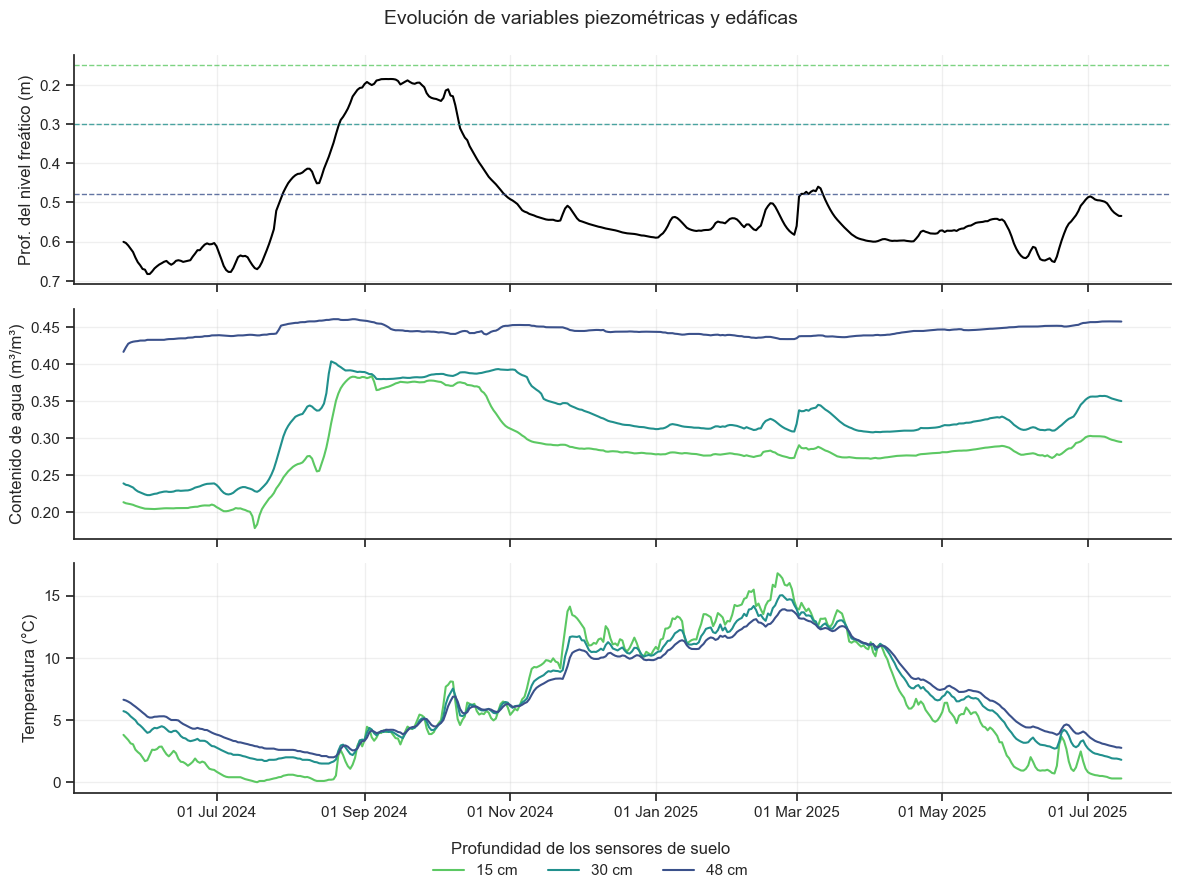

In [4]:
# Generar la figura base usando relplot
g = sns.relplot(
    data=df_long,
    x='Timestamps',
    y='Valor',
    row='Variable_label',      # Crea una fila por cada variable
    hue='Profundidad_label',   # Diferencia colores según profundidad
    kind='line',
    palette=palette_dict,      # Uso de diccionario de colores personalizado
    hue_order=full_depth_order,
    height=3,
    aspect=3.5,
    facet_kws={'sharey': False, 'sharex': True} # Eje X compartido, Eje Y independiente
)

# Personalización de ejes y paneles
g.set_titles("")  # Eliminar los títulos sobre cada panel
g.set_xlabels("") # Eliminar la etiqueta del eje X

# Iterar sobre cada panel (subplot) para aplicar estilos específicos
for i, (ax, title) in enumerate(zip(g.axes.flat, g.row_names)):
    # Etiqueta del eje Y: Texto normal y alineado
    ax.set_ylabel(title, fontweight='normal')
    
    # Configuración específica para el primer panel (Nivel Freático)
    if 'Prof. del nivel freático (m)' in title:
        ax.invert_yaxis() # Invertir eje
        
        # Dibujar líneas de referencia horizontales para la ubicación de sensores
        sensor_depths_m = [0.15, 0.30, 0.48]
        sensor_labels = ['15 cm', '30 cm', '48 cm']
        
        for d_m, lbl in zip(sensor_depths_m, sensor_labels):
            # Línea punteada del color correspondiente al sensor
            ax.axhline(y=d_m, color=palette_dict[lbl], linestyle='--', linewidth=1, alpha=0.8)

    # Formato de fecha en el eje X
    date_fmt = mdates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_fmt)


# Personalización de la leyenda
# Extraer los objetos (handles) y etiquetas actuales del primer gráfico
handles, labels = g.axes[0,0].get_legend_handles_labels()

# Filtrar la lista para excluir 'NA' (Nivel freático), ya que es la línea negra
clean_handles = [h for h, l in zip(handles, labels) if l != 'NA']
clean_labels = [l for l in labels if l != 'NA']

# Eliminar la leyenda por defecto a la derecha
g._legend.remove()

# Crear una nueva leyenda personalizada
g.fig.legend(
    clean_handles, 
    clean_labels, 
    loc='lower center', 
    bbox_to_anchor=(0.5, 0),
    ncol=3, # Disposición horizontal
    title="Profundidad de los sensores de suelo",
    frameon=False
)

# Ajustes finales
# Título principal de la figura
g.fig.suptitle("Evolución de variables piezométricas y edáficas", x=0.5, y=0.98, fontsize=14)
# Ajustes de espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.11) # Ajusta espacio disponible para subplots

plt.show()

#### Gráficos de dispersión

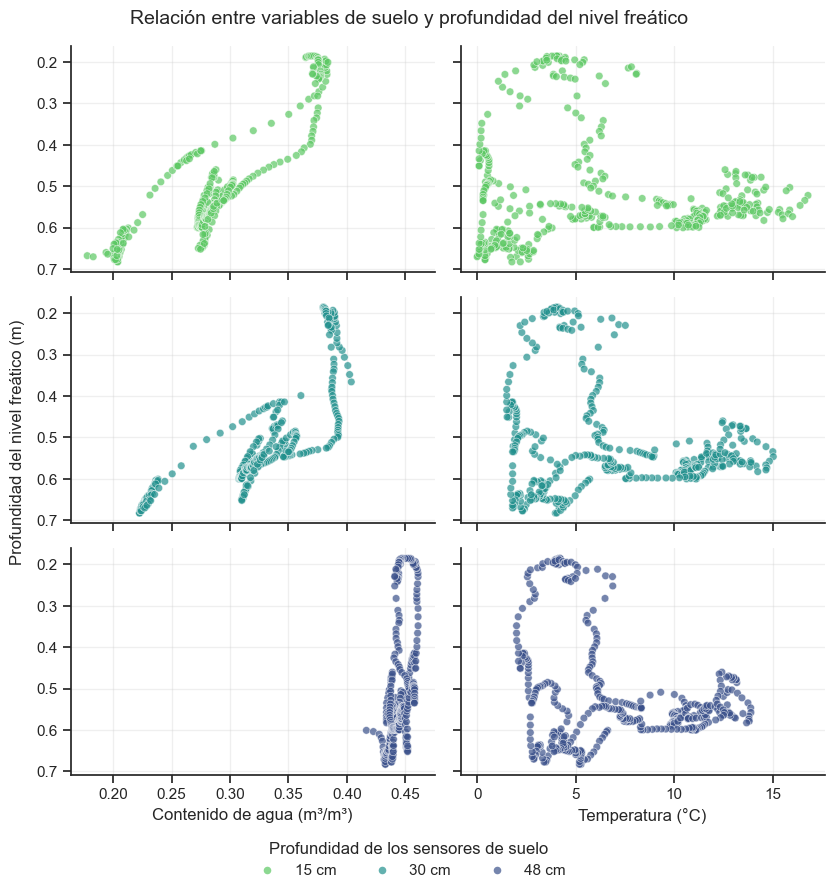

In [5]:
# Preparación de datos para scatter plot
# Filtrar los datos de suelo
df_soil = df_long[df_long['Sensor'] == 'Suelo'].copy()

# Extraer la serie de nivel freático (NA) y convertir en una columna
piezo_col = df_long[df_long['Profundidad_label'] == 'NA'].set_index('Timestamps')['Valor']

# Unir por fecha
df_scatter = df_soil.merge(piezo_col.rename('GWD'), left_on='Timestamps', right_index=True)

# Generar la figura base usando relplot scatter
g2 = sns.relplot(
    data=df_scatter,
    x='Valor',                  # Eje X: Variables de suelo
    y='GWD',                    # Eje Y: Nivel freático
    row='Profundidad_label',    # Filas: Profundidad (15, 30, 48)
    col='Variable_label',       # Columnas: Variable (Contenido-agua, Temperatura)
    hue='Profundidad_label',
    kind='scatter',
    palette=palette_dict,
    row_order=soil_depth_order, # 15, 30, 48
    hue_order=soil_depth_order,
    height=3,
    aspect=1.2,
    facet_kws={'sharey': True, 'sharex': 'col'}, 
    alpha=0.7,
    s=30
)

# Personalización de ejes y paneles
# Eliminar los títulos automáticos de los subplots
g2.set_titles("") 

# Inversión del eje Y
# Calcular min y max de los datos para establecer los límites manualmente
y_min = df_scatter['GWD'].min()
y_max = df_scatter['GWD'].max()
padding = (y_max - y_min) * 0.05 # Agregar un 5% de espacio
g2.set(ylim=(y_max + padding, y_min - padding))

# Configurar etiquetas del eje X en la fila inferior
g2.set_xlabels("") # Limpiar etiquetas automáticas
g2.axes[-1, 0].set_xlabel("Contenido de agua (m³/m³)")
g2.axes[-1, 1].set_xlabel("Temperatura (°C)")

# Etiqueta Global del Eje Y
g2.set_ylabels("") # Borrar etiquetas individuales automáticas
g2.fig.supylabel(
    "Profundidad del nivel freático (m)", 
    x=0.04, 
    size=plt.rcParams['axes.labelsize'], # Igualar tamaño al eje X
)

# Personalización de la leyenda
# Extraer handles/labels del primer panel
handles, labels = g2.axes[0,0].get_legend_handles_labels()

# Eliminar la leyenda automática
g2._legend.remove()

# Crear leyenda personalizada
g2.fig.legend(
    handles=handles,
    labels=labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0), 
    ncol=3,
    title="Profundidad de los sensores de suelo",
    frameon=False
)

# Ajustes finales
# Título principal
g2.fig.suptitle("Relación entre variables de suelo y profundidad del nivel freático", y=0.98, fontsize=14)

# Ajustes de espaciado
plt.tight_layout()
plt.subplots_adjust(top=0.94, bottom=0.13, left=0.11) # Ajusta espacio disponible para subplots

plt.show()